# Naive Bayes Classification

Naive Bayes models are simple algorithms that can efficiently classify categorical variables in high-dimensional datasets.This notebook will provide a brief and clear introduction to these tools and will demonstrate the nuts and bolts that make them work. First, some preliminaries:

In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter


The algorithms take their name from Bayes's theorem, which defines conditional probability.
$$Bayes Theorem: P(y | X)= \frac{P(X | y)P(y)}{P(X)}$$

If the cool kids are around we read this as:

$$ Posterior Probability = \frac{Likelihood \times Prior Probability}{Marginal Probability}$$

Naive Bayes classification is the process of finding the probability of a particular outcome given a set of feature, which we can write as $P(Outcome|Features)$. According to Bayes's theorem that calculation is

$$P(Outcome | Features)= \frac{P(Features | Outcome)P(Outcome)}{P(Features)}$$

Again, for the cool kids:

- P(Outcome | Features) is the posterior probability of target given the predictors (features)
- P(Outcome) is the prior probability of target (prior to seeing features)
- P(Features | Outcome) is the probability of observing the particular set of features given the target
- P(Features) is the prior or unconditional probability of the predictors arising  

Given two possible outcomes, we can directly compare the two to see which is more probable.

$$P(Outcome_1 | Features)= \frac{P(Features | Outcome_1)P(Outcome_1)}{P(Features)}$$

$$\implies P(Features) = \frac{P(Features | Outcome_1)P(Outcome_1)}{P(Outcome_1 | Features)}$$

Thus, it must also be the case that... 

$$P(Outcome_2 | Features)= \frac{P(Features | Outcome_2)P(Outcome_2)}{P(Features)}$$

$$\implies P(Features) = \frac{P(Features | Outcome_2)P(Outcome_2)}{P(Outcome_2 | Features)}$$

Meaning...

$$ \frac{P(Features | Outcome_1)P(Outcome_1)}{P(Outcome_1 | Features)} = \frac{P(Features | Outcome_2)P(Outcome_2)}{P(Outcome_2 | Features)}$$

$$ \implies \frac{P(Outcome_1 | Features)}{P(Outcome_2 | Features)} = \frac{P(Features | Outcome_1)P(Outcome_1)} {P(Features | Outcome_2)P(Outcome_2)}$$

The ratio of the conditional probabilities is equal to a ratio of the probability of the data given the outcome times the unconditional probability of the outcome. What makes the model "naive" are the assumptions about the generative model producing the data associated with each label. 

The naive bayes probability model assumes that the features are independent, so that 

$$P(feature_{i}|outcome, feature_{1},...,feature_{i-1}, feature_{i+1},...,feature_{n}) = P(feature_{i}|outcome)$$

and accordingly

$$P(outcome| feature_{1},...,feature_{n}) = \frac{P(outcome) \prod_{i=0}^{n}P(feature_{i}|outcome)}{P(feature_{1},...,feature_{n})}$$

The Naive Bayes classifier takes the naive bayes probability model and adds a decision rule - that the more probable outcome (given the features) is picked by the `maximum a posterior` and a class label is predicted via:

$$\hat{outcome} = \underset{outcome}{\operatorname{argmax}} P(outcome)\prod_{i=0}^{n}P(feature_{i}|outcome) $$

From an empirical standpoint this is super easy to implement - we just estimate the unconditional probability of the outcome via the frequency with which it occurs in the training dataset. Various naive bayes classifiers differ in the assumptions made about the distribution of $$P(feature_{i} | outcome)$$. With discrete/categorical data it is typically assumed that discrete/categorical values are distributed according to a categorical distribution (this is a generalization of the Bernoulli distribution). 

The probability of category $t$ in feature $i$ given class $c$ is estimated to be: 

$$P(feature_{i} = t | outcome = c; \alpha) = \frac{N_{tic}+\alpha}{N_{c} + \alpha n_{i}}$$

That $\alpha$ is called the Laplace smoothing parameter and it is needed to deal with situations where a particular value does not arise in the training data. 

In [2]:

data = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data" 
car_df = pd.read_csv(data, names=['buying','maint','doors','persons','lug_boot','safety','class'], sep=",")

features = car_df.columns.tolist()
features.remove('class')
features   

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

In [3]:
car_df['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

This dataset has six features and single label. All of the features are strings. To use the naive bayes classifier algorithm we need all of the variables to be coded as integers. The pandas `factorize()` method is useful for this task, as is sklearn's `OrdinalEncoder`.

In [4]:
encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(car_df[features])
car_df_encoded = pd.DataFrame(data_encoded, columns=features)
data_encoded

array([[3., 3., 0., 0., 2., 1.],
       [3., 3., 0., 0., 2., 2.],
       [3., 3., 0., 0., 2., 0.],
       ...,
       [1., 1., 3., 2., 0., 1.],
       [1., 1., 3., 2., 0., 2.],
       [1., 1., 3., 2., 0., 0.]])

In [5]:
car_df_encoded

,buying,maint,doors,persons,lug_boot,safety
0,3.0,3.0,0.0,0.0,2.0,1.0
1,3.0,3.0,0.0,0.0,2.0,2.0
2,3.0,3.0,0.0,0.0,2.0,0.0
3,3.0,3.0,0.0,0.0,1.0,1.0
4,3.0,3.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...
1723,1.0,1.0,3.0,2.0,1.0,2.0
1724,1.0,1.0,3.0,2.0,1.0,0.0
1725,1.0,1.0,3.0,2.0,0.0,1.0
1726,1.0,1.0,3.0,2.0,0.0,2.0


In [6]:
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(car_df['class'])
car_df_encoded['class'] = target_encoded
encoder.inverse_transform(target_encoded)
car_df_encoded.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3.0,3.0,0.0,0.0,2.0,1.0,2
1,3.0,3.0,0.0,0.0,2.0,2.0,2
2,3.0,3.0,0.0,0.0,2.0,0.0,2
3,3.0,3.0,0.0,0.0,1.0,1.0,2
4,3.0,3.0,0.0,0.0,1.0,2.0,2


In [7]:
car_df_encoded['maint'].groupby(car_df_encoded['buying']).value_counts()

buying  maint
0.0     0.0      108
        1.0      108
        2.0      108
        3.0      108
1.0     0.0      108
        1.0      108
        2.0      108
        3.0      108
2.0     0.0      108
        1.0      108
        2.0      108
        3.0      108
3.0     0.0      108
        1.0      108
        2.0      108
        3.0      108
Name: maint, dtype: int64

Now we need to test that the independence assumption is satisfied:

In [8]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(car_df_encoded.values, i) for i in range(len(features))]
vif["Features"] = features
vif

,VIF,Features
0,2.537474,buying
1,2.522938,maint
2,2.443242,doors
3,2.165404,persons
4,2.290247,lug_boot
5,2.240569,safety


In [9]:
#split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(car_df_encoded.drop('class', axis=1), car_df_encoded['class'], test_size=0.3, random_state=143)
#fit the model using the training data
cnb = CategoricalNB()
cnb.fit(X_train, y_train)
#check performance
prediction = cnb.predict(X_test)
probability = cnb.predict_proba(X_test)
# how did our model perform?
number_wrong = (y_test != prediction).sum()

print("CategoricalNB")
print("=" * 30)
print('Misclassified samples: {}'.format(number_wrong))
accuracy = accuracy_score(y_test, prediction)
print('Accuracy: {:.2f}'.format(accuracy))

CategoricalNB
Misclassified samples: 82
Accuracy: 0.84


**Gaussian Naive Bayes** operates on the assumption of a normal distribution of probabilities. That is to say the feature frequencies are distributed by the Gaussian law:

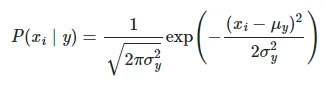

The formula is based on the mean (μ) and Bessel corrected variance (σ) of the frequency of each feature in the class of label.

**Multinomial Naive Bayes** assumes the distribution of probabilities for each event can be calculated via this formula:

$$P(feature_{i} = t | outcome = c; \alpha) = \frac{N_{tic}+\alpha}{N_{c} + \alpha n_{i}}$$

$N_{c}$ is the total number of features of the event i (total number of words in all spam messages), $N_tic$ is a count of each feature, and n is the number of features with α being a Laplace smoothing  parameter to negate the influence of missing types in the training data. 

**Bernoulli Naive Bayes** is similar to the multinomial approach, but this version works better when the features are a set of boolean values instead of frequencies.

$$P(x_i|y) = P(i|y)x_i + (1 - P(i|y))(1-x_i)$$

This algorithm penalizes the non-occurrence of a feature while the multinomial approach uses the smoothing parameter for the absent values. 

# Classifying Spam

In [10]:
import urllib.request
import zipfile
import io
    
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[0]
file = zip_file_object.open(first_file)
content = file.read()

df = pd.read_table(io.StringIO(content.decode('utf-8')), names=['label','sms_message'])


In [11]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Again, we can't have strings as labels. We need numerical values to input into the algorithm.  

In [12]:
# Conversion
df['label'] = df.label.map({'ham':0, 'spam':1})


This all looks like nonsense, but it truly is data. 5,572 rows of nonsense data. To turn these text messages into numerical data we need to do some processing. `Bag of Words`(BoW) references classification tasks involving text data. We will take each message and count the frequency of the words in the row. The order of the words is not important, it is just treated as a mixed up 'bag of words'. We will convert these messages into a matrix with a message on each row and every word that appears in the file as a unique column. The cell (row,column) values will count the frequency with which each word occurs in the message. You can find a tool to do this in sklearn - it is the`CountVectorizer` method. Here is an example:


In [16]:
# some messages
messages = ['On Wisconsin!',
                'If you want to be a Badger just come along with me',
                'Varsity, Varsity, U-rah-rah! Wisconsin,',
                'When you\'ve said Wisconsin, you\'ve said it all']

from sklearn.feature_extraction.text import CountVectorizer # Import and initialize CountVectorizer 
count_vector = CountVectorizer()
count_vector.fit(messages)
features = count_vector.get_feature_names()
features

['all',
 'along',
 'badger',
 'be',
 'come',
 'if',
 'it',
 'just',
 'me',
 'on',
 'rah',
 'said',
 'to',
 'varsity',
 've',
 'want',
 'when',
 'wisconsin',
 'with',
 'you']

In [17]:
message_array = count_vector.transform(messages).toarray()
message_array

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2]],
      dtype=int64)

In [18]:
freq_table = pd.DataFrame(data=message_array, columns=features)
freq_table

,all,along,badger,be,come,if,it,just,me,on,rah,said,to,varsity,ve,want,when,wisconsin,with,you
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,1,1,1,1,1,0,1,1,0,0,0,1,0,0,1,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,0,2,0,0,2,0,1,1,0,2


# Practice

Now it is your turn to apply the algorithm to the sms message data. 

1. Split the data into training and testing sets. Use the naming conventions (x_train, x_test, y_train, y_test). Use `train_test_split` from `sklearn.model_selection` as was previously demonstrated. 

In [22]:
# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df["sms_message"], df["label"], random_state=1)

2. Create a count vector for each word in the dataset.

In [23]:
#use the count_vectorizer!
count_vector = CountVectorizer()
training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

3. If you have named things correctly the code above should fit the training that testing data to their respective matricies. Last class we fit the MNLogit model. Today, let's do the same with the MultinomialNB() model. Enter the correct fit command below:

In [24]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB()

4. Recover the predictions from the testing data.

In [27]:
predictions = naive_bayes.predict(testing_data)
print(predictions)

[0 0 0 ... 0 1 0]


5. Calculate the quality of your model. There are several measures that we will be interested in. `Accuracy` is the ratio of correct predictions to total predictions (test data points).`Precision` is defined as the number of true positives divided by the sum of both true positives  and false positives. `Recall` is defined as the number of true positives divided by the sum of both true positives  and false negatives. Accuracy is calculated below, read the `sklearn.metrics` page to calculate precision and recall.


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('precision score: ', format(precision_score(y_test, predictions, pos_label=1)))
print('recall score: ', format(recall_score(y_test, predictions, pos_label=1)))
print('f1 score: ', format(f1_score(y_test, predictions, pos_label=1)))

Accuracy score:  0.9885139985642498
precision score:  0.9720670391061452
recall score:  0.9405405405405406
f1 score:  0.9560439560439562
